In [67]:
!git clone https://github.com/CSCphilip/dd2424-project.git

fatal: destination path 'dd2424-project' already exists and is not an empty directory.


In [68]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [69]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = "cpu"

True
0
1


'Tesla K80'

In [73]:
# Loading data
# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

def load_data(data_dir):
    X_train = np.load(data_dir)
    print(f"Shape of training data: {X_train.shape}")
    print(f"Data type: {type(X_train)}")
    print(type(X_train[0][0][0][0]))
    return X_train

# Create numpy arrays from npy files
X_train_cage = load_data('cage.npy')
X_train_trump = load_data('trump.npy')

# Convert to range [0, 1]
X_train_cage /= 255
X_train_trump /= 255

# Create array with both cage and trump images
X_train_cage_trump = np.append(X_train_cage, X_train_trump, axis=0)

# Normalize to make training easier
means = np.mean(X_train_cage_trump, axis=(0, 1, 2))
print(means)

X_train_cage_trump -= means
X_train_cage -= means
X_train_trump -= means

Shape of training data: (306, 64, 64, 3)
Data type: <class 'numpy.ndarray'>
<class 'numpy.float64'>
Shape of training data: (331, 64, 64, 3)
Data type: <class 'numpy.ndarray'>
<class 'numpy.float64'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


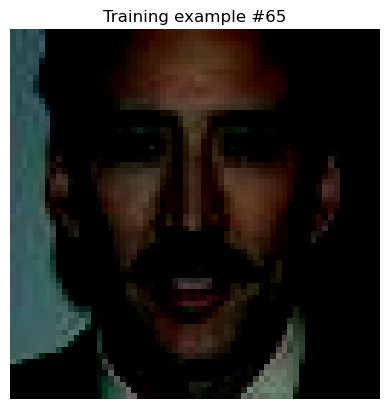

In [76]:
# Display random image of cage for testing purposes
random_image = random.randint(0, len(X_train_cage))
img = X_train_cage[random_image]
plt.imshow(img)
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


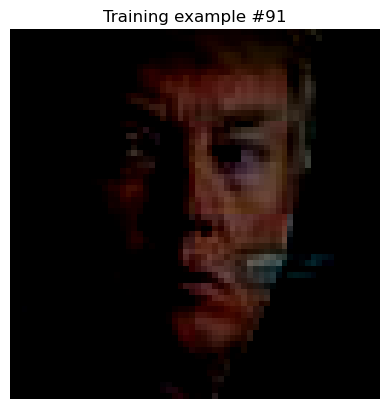

In [55]:
# Display random image of trump for testing purposes
random_image = random.randint(0, len(X_train_trump))
img = X_train_trump[random_image]
plt.imshow(img)
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

In [56]:
class CustomImageDataset(Dataset):
    def __init__(self, X):
      self.X = X
        
    def __len__(self):
      return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        return image

In [57]:
batch_size = 32

X_train_cage = X_train_cage.astype(np.float32)
X_train_trump = X_train_trump.astype(np.float32)
X_train_cage_trump = X_train_cage.astype(np.float32)

X_train_cage = torch.from_numpy(X_train_cage)
X_train_trump = torch.from_numpy(X_train_trump)
X_train_cage_trump = torch.from_numpy(X_train_cage_trump)

X_train_cage = X_train_cage.to(device)
X_train_trump = X_train_trump.to(device)

cage_dataset = CustomImageDataset(X_train_cage)
cage_dl = DataLoader(cage_dataset, batch_size, shuffle=True)

trump_dataset = CustomImageDataset(X_train_trump)
trump_dl = DataLoader(trump_dataset, batch_size, shuffle=True)

#cage_trump_dataset = CustomImageDataset(X_train_cage_trump)
#cage_trump_dl = DataLoader(cage_trump_dataset, batch_size, shuffle=True)

In [58]:
# The face swap model
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, 4, stride=2),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, stride=1),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(in_features=32*29*29, out_features=1000),
    )
    self.decoder_cage = nn.Sequential(
      nn.Linear(in_features=1000, out_features=32*29*29),
      nn.ReLU(),
      nn.Unflatten(1, (32, 29, 29)),
      nn.ConvTranspose2d(32, 16, 4, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 8, 3, stride=1),
      nn.ReLU(),
      nn.ConvTranspose2d(8, 3, 3, stride=1),
      nn.ReLU(),
    )
    self.decoder_trump = nn.Sequential(
      nn.Linear(in_features=1000, out_features=32*29*29),
      nn.ReLU(),
      nn.Unflatten(1, (32, 29, 29)),
      nn.ConvTranspose2d(32, 16, 4, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 8, 3, stride=1),
      nn.ReLU(),
      nn.ConvTranspose2d(8, 3, 3, stride=1),
      nn.ReLU(),
    )

  def forward(self, x, y):
    x = x.permute(0, 3, 1, 2)
    x = self.encoder(x)
    if y == 0:
      x = self.decoder_cage(x)
    else: 
      x = self.decoder_trump(x)
    x = x.permute(0, 2, 3, 1)
    return x

In [59]:
ae = AutoEncoder().to(device)
for X in cage_dl:

  res = ae(X,1)
  break

In [60]:
learning_rate = 3e-5
epochs = 100

loss_fn = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam([{'params': ae.encoder.parameters()},
                          {'params': ae.decoder_cage.parameters()}], lr=learning_rate, betas=(0.4, 0.999))
optimizer_2 = torch.optim.Adam([{'params': ae.encoder.parameters()},
                          {'params': ae.decoder_trump.parameters()}], lr=learning_rate, betas=(0.4, 0.999))

In [61]:
def train_loop(dataloader_cage, dataloader_trump, model, loss_fn, optimizer_1, optimizer_2):
  cage_iterator = iter(dataloader_cage)
  trump_iterator = iter(dataloader_trump)
  while True:
    try:
      cage_batch = next(cage_iterator)
      trump_batch = next(trump_iterator)
    except StopIteration:
      return loss
    #Forward
    cage_out = model(cage_batch, 0)
    trump_out = model(trump_batch, 1)
    
    loss_1 = loss_fn(cage_out, cage_batch)
    loss_2 = loss_fn(trump_out, trump_batch)
    loss = loss_1.item() + loss_2.item()
          
    #Backward
    optimizer_1.zero_grad()
    optimizer_2.zero_grad()
    loss_1.backward()
    loss_2.backward()
    optimizer_1.step()
    optimizer_2.step()


In [62]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(cage_dl, trump_dl, ae, loss_fn, optimizer_1, optimizer_2)
    print(f"loss: {loss:>7f}")
print("Done!")

Epoch 1
-------------------------------
loss: 0.124225
Epoch 2
-------------------------------
loss: 0.116791
Epoch 3
-------------------------------
loss: 0.116659
Epoch 4
-------------------------------
loss: 0.118696
Epoch 5
-------------------------------
loss: 0.109443
Epoch 6
-------------------------------
loss: 0.099428
Epoch 7
-------------------------------
loss: 0.103708
Epoch 8
-------------------------------
loss: 0.105542
Epoch 9
-------------------------------
loss: 0.100934
Epoch 10
-------------------------------
loss: 0.093930
Epoch 11
-------------------------------
loss: 0.092682
Epoch 12
-------------------------------
loss: 0.106574
Epoch 13
-------------------------------
loss: 0.100081
Epoch 14
-------------------------------
loss: 0.087346
Epoch 15
-------------------------------
loss: 0.099426
Epoch 16
-------------------------------
loss: 0.100181
Epoch 17
-------------------------------
loss: 0.091945
Epoch 18
-------------------------------
loss: 0.104537
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


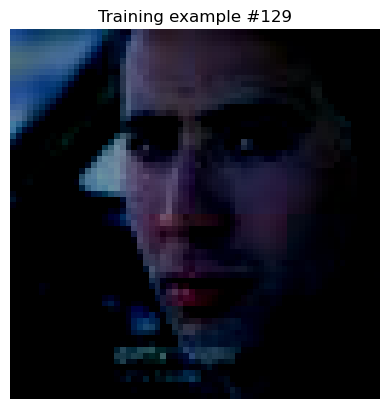

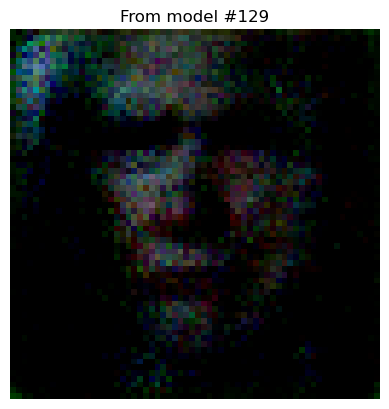

In [65]:
# Test image rendition
# Display random image of cage
random_image = random.randint(0, len(X_train_cage))
img = X_train_cage[random_image]
#img += torch.from_numpy(means).to(device)
img_tensor = img.unsqueeze(0)
res = ae(img_tensor, 1)
res = res[0]
res = res.cpu().detach().numpy()
plt.imshow(img.cpu())
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

plt.imshow(res)
plt.title(f"From model #{random_image}")
plt.axis('off')
plt.show()